## Import

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 
from scipy.stats import norm, linregress
#from gpyrn import covfunc, meanfunc, meanfield
import exoplanet as xo
from scipy.optimize import minimize
from scipy.stats import norm
import csv
from scipy import stats
from multiprocessing import Pool
import emcee
import corner
from loguniform import LogUniform, ModifiedLogUniform
import sys
sys.path.append(os.path.abspath("/home/paul/Bureau/IRAP/TediGP"))
import process, kernels, means

## Load 2 first componant

In [23]:
eigen2vectors = np.load('/home/paul/Bureau/IRAP/TablesAU_MIC/2firstcomponent.npy', allow_pickle=True)
times = np.load('/home/paul/Bureau/IRAP/TablesAU_MIC/readyforwPCA_epoc.npy')

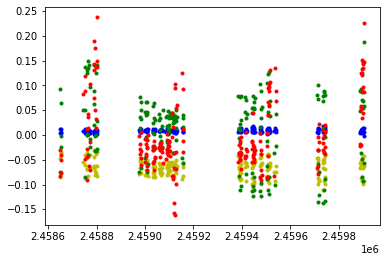

In [149]:
plt.plot(times[:-1], eigen2vectors[0][:-1], 'b.')
plt.plot(times[:-1], eigen2vectors[1][:-1], 'y.')
plt.plot(times[:-1], eigen2vectors[2][:-1], 'g.')
plt.plot(times[:-1], eigen2vectors[3][:-1], 'r.')

plt.show()

## Periodograms
### 1st component

Peak frequency = 
4.872250163692226


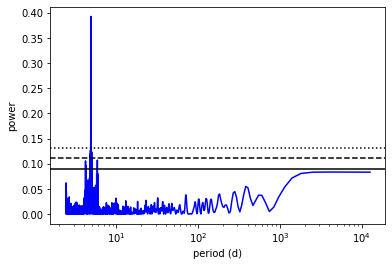

In [150]:
frequency, power = LombScargle(times[:-1], eigen2vectors[0][:-1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'b')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times[:-1], eigen2vectors[0][:-1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### 2nd component

Peak frequency = 
4.872250163692226


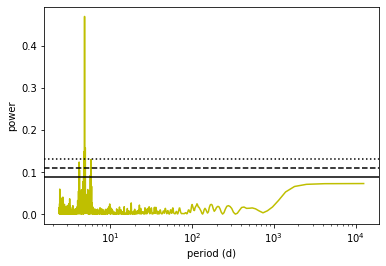

In [151]:
frequency, power = LombScargle(times[:-1], eigen2vectors[1][:-1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'y')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times[:-1], eigen2vectors[1][:-1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### 3rd component

Peak frequency = 
4.872250163692226


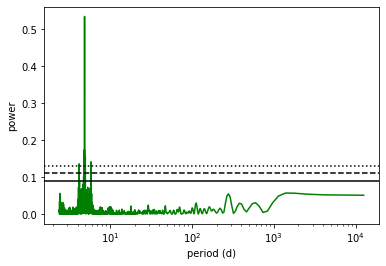

In [22]:
frequency, power = LombScargle(times[:-1], eigen2vectors[2][:-1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'g')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times[:-1], eigen2vectors[2][:-1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

Peak frequency = 
359.01523349035


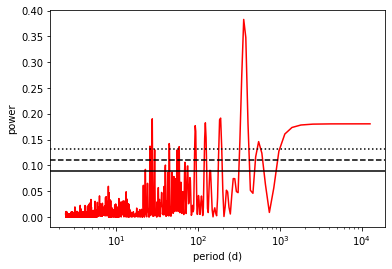

In [145]:
frequency, power = LombScargle(times[:-1], eigen2vectors[3][:-1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times[:-1], eigen2vectors[3][:-1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

## First component GP 

In [27]:
print(2*(np.max(eigen2vectors[0][:-1])- np.min(eigen2vectors[0][:-1])))
print(np.std(eigen2vectors[0][:-1]))
print(10*(np.max(times[:-1])-np.min(times[:-1])))


0.0386300881860595
0.003312406693340408
12565.53317216225


In [56]:
#Priors
n_eta1 = ModifiedLogUniform(0.003, 0.4)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.003, 0.4)

In [57]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [58]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0][:-1]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[0][:-1], yerr = 1e-12 * np.identity(times[:-1].size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [59]:
ndim = priors().size 
nwalkers = 2*ndim

In [60]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [06:51<00:00, 24.31it/s]


State([[3.40803027e-03 1.30654508e+02 4.85687711e+00 9.03382438e-01
  1.28178191e-03]
 [3.12371124e-03 1.70500545e+02 4.85582510e+00 7.87555171e-01
  1.34928568e-03]
 [3.58517542e-03 1.65762642e+02 4.85124084e+00 7.78159656e-01
  1.25265375e-03]
 [3.65720493e-03 1.32341716e+02 4.85699003e+00 7.09850158e-01
  1.26968370e-03]
 [2.75865514e-03 1.23890872e+02 4.85064066e+00 8.20648671e-01
  1.34922729e-03]
 [4.58854251e-03 1.48757416e+02 4.86300672e+00 1.06055290e+00
  1.31509568e-03]
 [2.98320906e-03 1.23796631e+02 4.86031557e+00 6.94692648e-01
  1.20988261e-03]
 [2.80903156e-03 1.25186940e+02 4.86271644e+00 8.83637961e-01
  1.27942680e-03]
 [2.93651171e-03 1.83269256e+02 4.85923432e+00 6.33224073e-01
  1.40990609e-03]
 [3.09628328e-03 1.41911237e+02 4.86057967e+00 8.19591158e-01
  1.34958944e-03]], log_prob=[1036.44553238 1036.16164775 1035.38085425 1034.96229649 1034.3523671
 1033.21675587 1036.32920679 1035.40766005 1034.17250089 1036.3812803 ], blobs=None, random_state=('MT19937', arr

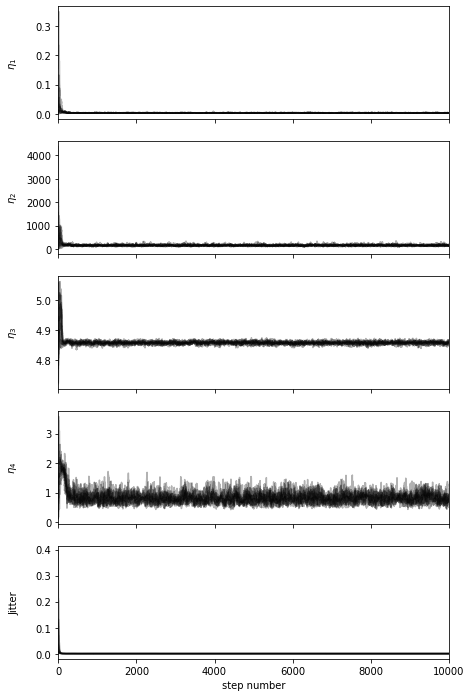

In [61]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

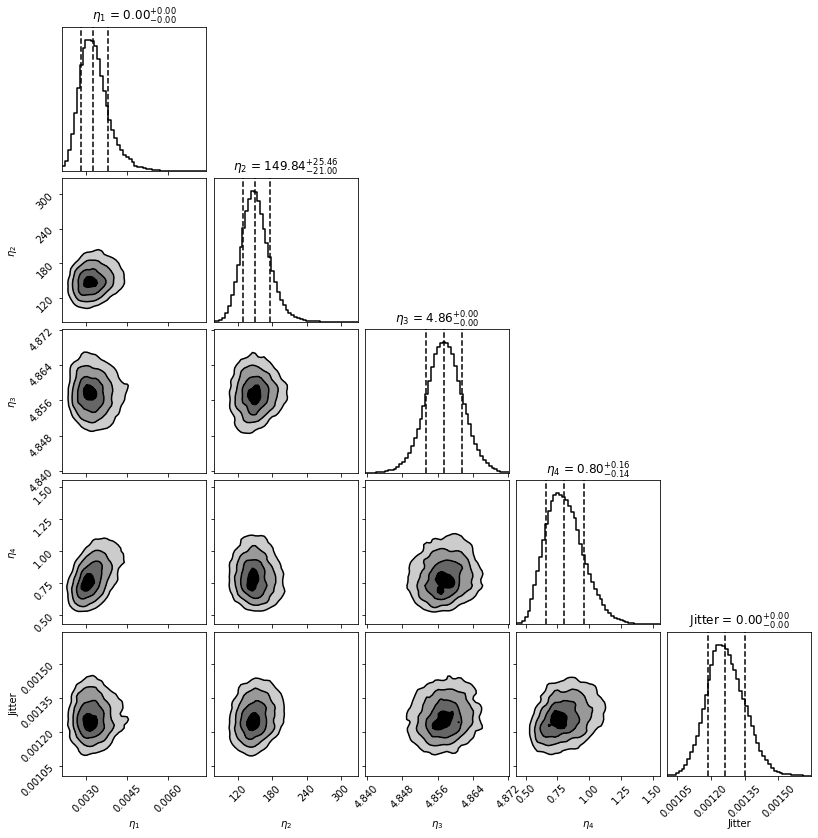

In [62]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False)
plt.show()

In [63]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[0][:-1],yerr = 1e-12 * np.identity(times[:-1].size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

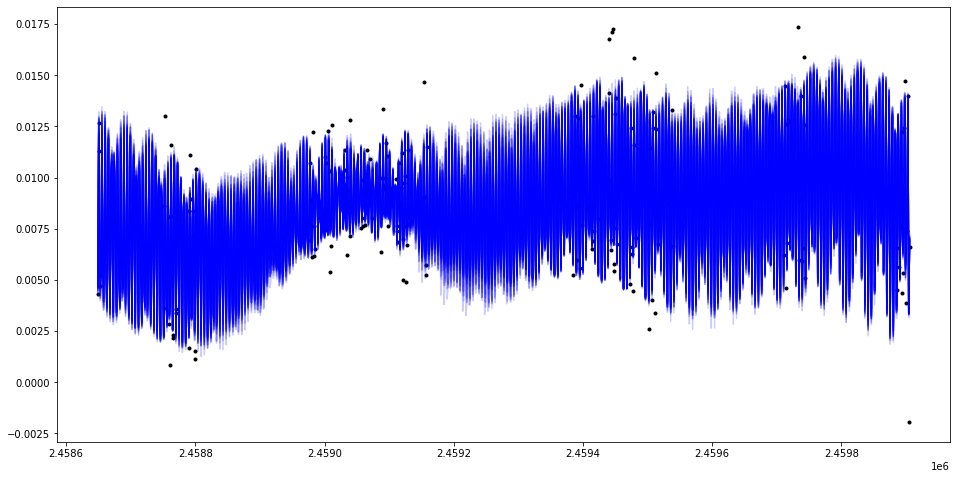

In [64]:
plt.figure(figsize=(16, 8))

plt.plot(times[:-1], eigen2vectors[0][:-1],'k.')
tplot = np.linspace(np.min(times), np.max(times), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
plt.show()

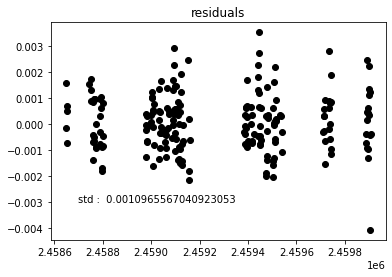

In [67]:
y_sample = Display(flat_samples[0,:], times[:-1])

residuals = eigen2vectors[0][:-1] - y_sample

plt.plot(times[:-1], residuals, 'ok')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, -0.003) )
plt.title('residuals')
plt.show()

## 2nd component GP

In [101]:
print(2*(np.max(eigen2vectors[1][:-1])- np.min(eigen2vectors[1][:-1])))
print(np.std(eigen2vectors[1][:-1]))
print(10*(np.max(times[:-1])-np.min(times[:-1])))

0.1610875740128667
0.01622216136157789
12565.53317216225


In [102]:
#Priors
n_eta1 = ModifiedLogUniform(0.016, 0.16)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.016, 0.16)

In [103]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [104]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[1][:-1]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[1][:-1], yerr = 1e-12 * np.identity(times[:-1].size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [105]:
ndim = priors().size 
nwalkers = 2*ndim

In [106]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [07:06<00:00, 23.42it/s]


State([[2.35182958e-02 1.12802125e+02 4.85919811e+00 1.05509793e+00
  4.45926116e-03]
 [1.52746953e-02 1.64831691e+02 4.86080394e+00 6.14747911e-01
  4.89747953e-03]
 [1.65442113e-02 1.65536930e+02 4.86097339e+00 7.72881364e-01
  4.53718791e-03]
 [2.22906571e-02 1.35509778e+02 4.86009421e+00 1.08219447e+00
  4.48983165e-03]
 [1.73178479e-02 1.36364081e+02 4.86106343e+00 9.08415807e-01
  4.39922472e-03]
 [1.28447035e-02 1.28463033e+02 4.85987208e+00 6.89763363e-01
  4.79919298e-03]
 [1.97308969e-02 1.21519621e+02 4.85349597e+00 1.06956875e+00
  4.16669716e-03]
 [1.39622034e-02 9.84713558e+01 4.85061288e+00 7.34056828e-01
  4.53875753e-03]
 [2.14394033e-02 1.53402654e+02 4.86649946e+00 7.53483934e-01
  4.56566275e-03]
 [1.39627662e-02 1.34869465e+02 4.86171807e+00 8.49705770e-01
  4.51667818e-03]], log_prob=[744.96988248 746.94256879 749.29829206 747.86694818 750.15261112
 747.52669195 746.11689457 746.25622222 743.63943068 749.48663284], blobs=None, random_state=('MT19937', array([10272

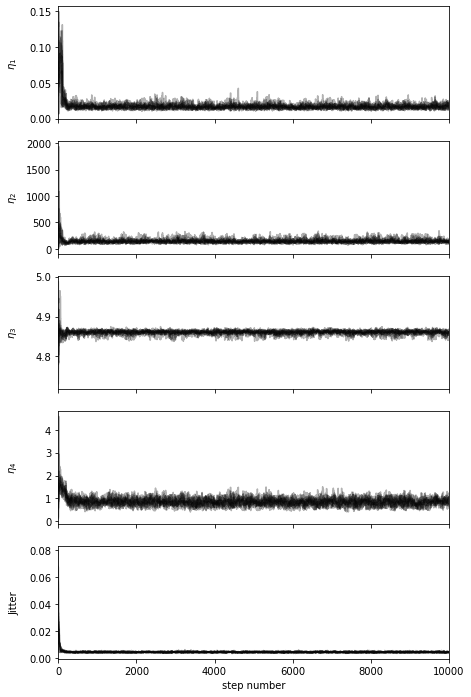

In [107]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

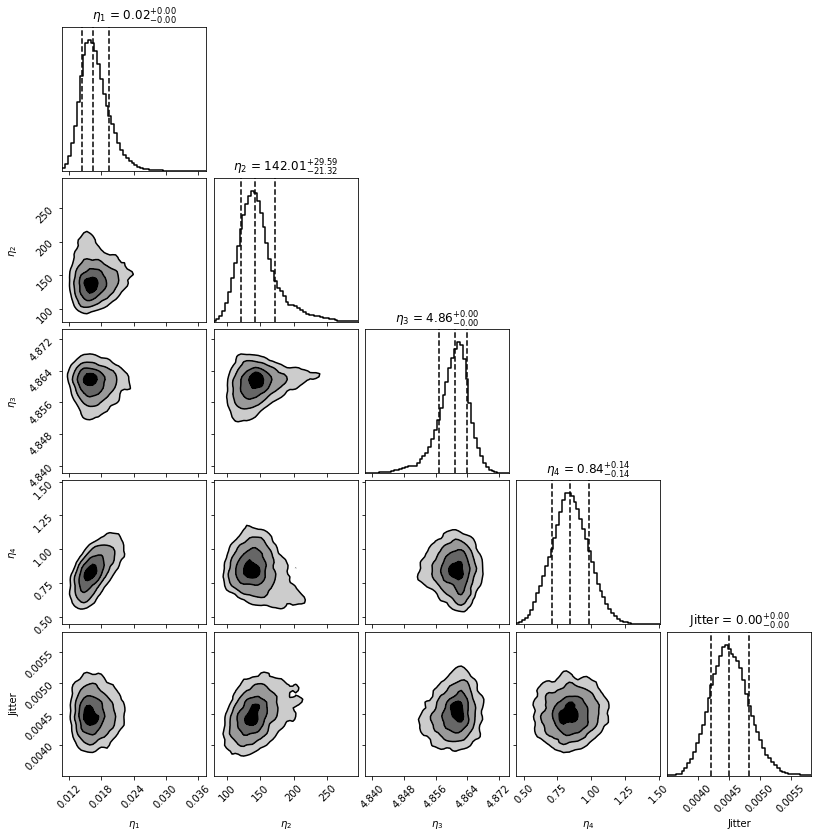

In [108]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False)
plt.show()

In [109]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[1][:-1]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[1][:-1],yerr = 1e-12 * np.identity(times[:-1].size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

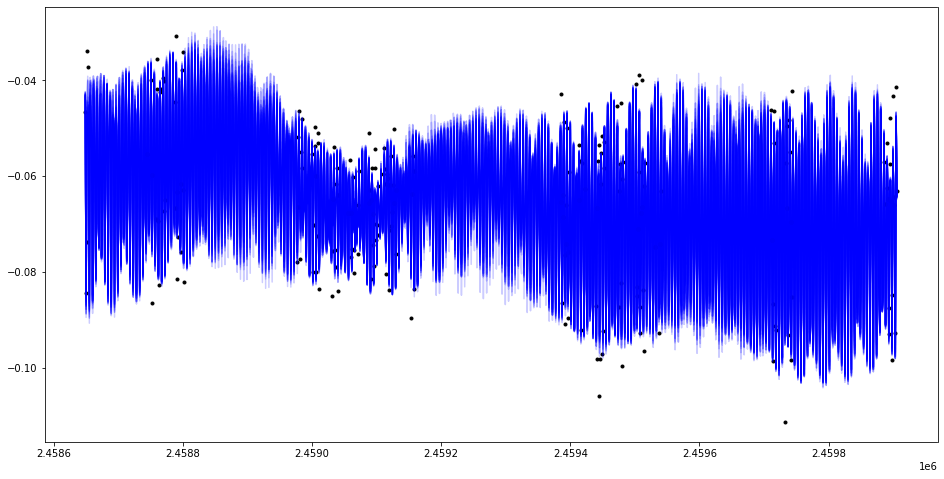

In [110]:
plt.figure(figsize=(16, 8))

plt.plot(times[:-1], eigen2vectors[1][:-1],'k.')
tplot = np.linspace(np.min(times[:-1]), np.max(times[:-1]), 1000)
 
for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
plt.show()

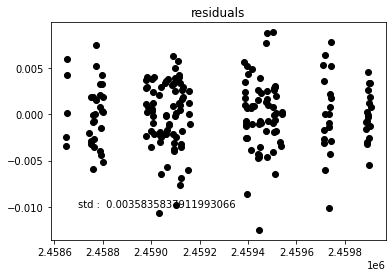

In [111]:
y_sample = Display(flat_samples[0,:], times[:-1])

residuals = eigen2vectors[1][:-1] - y_sample

plt.plot(times[:-1], residuals, 'ok')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, -0.01) )
plt.title('residuals')
plt.show()

### 3rd Component

In [134]:
print(2*(np.max(eigen2vectors[2][:-1])- np.min(eigen2vectors[2][:-1])))
print(np.std(eigen2vectors[2][:-1]))
print(10*(np.max(times[:-1])-np.min(times[:-1])))

0.6513356573721459
0.06724968047191178
12565.53317216225


In [135]:
#Priors
n_eta1 = ModifiedLogUniform(0.065, 0.65)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.065, 0.65)

In [136]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [137]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[2][:-1]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[2][:-1], yerr = 1e-12 * np.identity(times[:-1].size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [138]:
ndim = priors().size 
nwalkers = 2*ndim

In [139]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [06:10<00:00, 27.02it/s]


State([[5.92816822e-02 1.26891620e+02 4.86327453e+00 8.32496434e-01
  8.45640732e-03]
 [5.24147332e-02 1.31404985e+02 4.86119681e+00 7.28991986e-01
  9.84061779e-03]
 [8.69295058e-02 1.38767699e+02 4.85507085e+00 8.55931832e-01
  8.92542792e-03]
 [5.68343072e-02 1.30132052e+02 4.86184831e+00 7.83598048e-01
  8.74518940e-03]
 [7.46193549e-02 1.09036753e+02 4.85128616e+00 8.44951560e-01
  9.57415663e-03]
 [5.01430763e-02 1.37204921e+02 4.86009337e+00 8.27147454e-01
  9.66743928e-03]
 [7.25327532e-02 1.40557794e+02 4.85969809e+00 9.19747265e-01
  9.31437241e-03]
 [5.98942032e-02 1.13872857e+02 4.86138015e+00 9.63179253e-01
  9.44699358e-03]
 [5.83625693e-02 1.36046653e+02 4.85951108e+00 8.16996743e-01
  1.01670739e-02]
 [6.65706742e-02 1.35995098e+02 4.85667366e+00 9.10039554e-01
  9.59943862e-03]], log_prob=[549.15511618 548.49933724 545.57947165 549.85641334 543.69270798
 547.49967141 550.56953999 547.40831157 549.46721327 549.37947152], blobs=None, random_state=('MT19937', array([  510

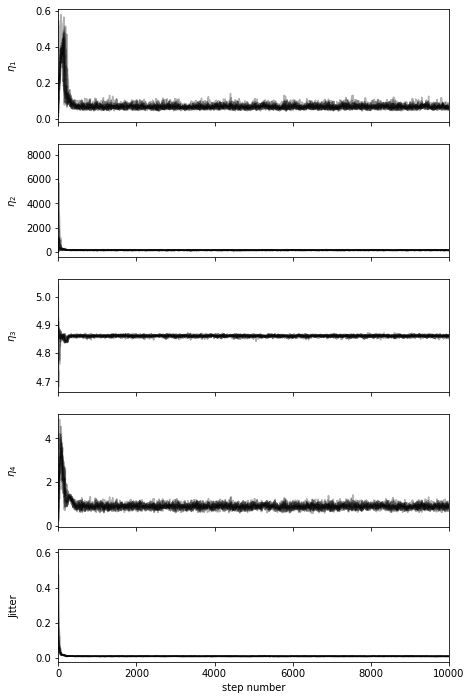

In [140]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

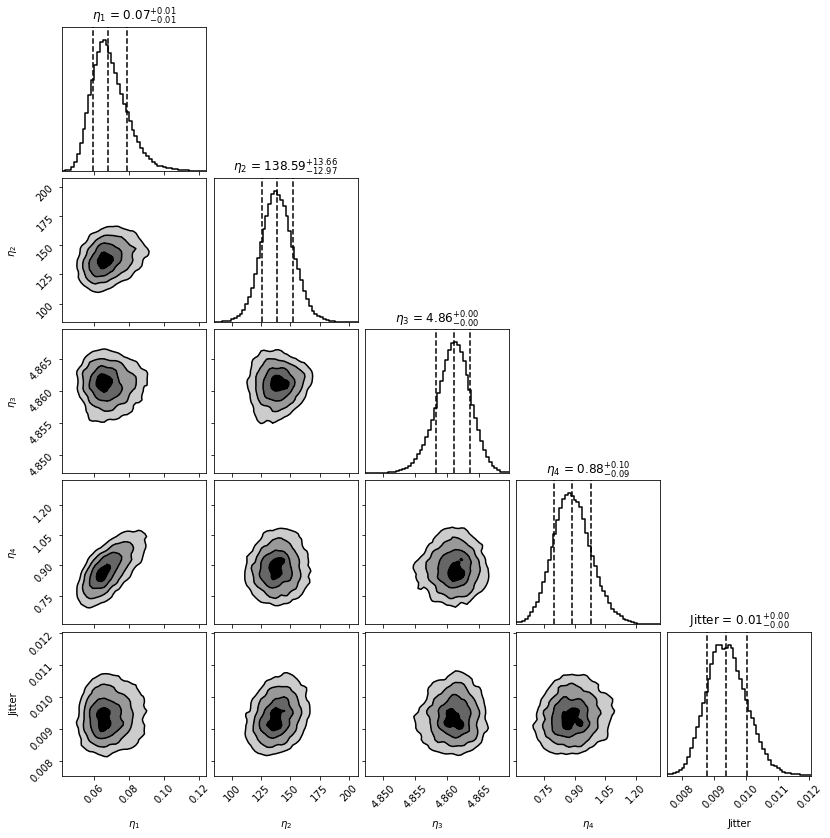

In [141]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False)
plt.show()

In [142]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[2][:-1]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[2][:-1],yerr = 1e-12 * np.identity(times[:-1].size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

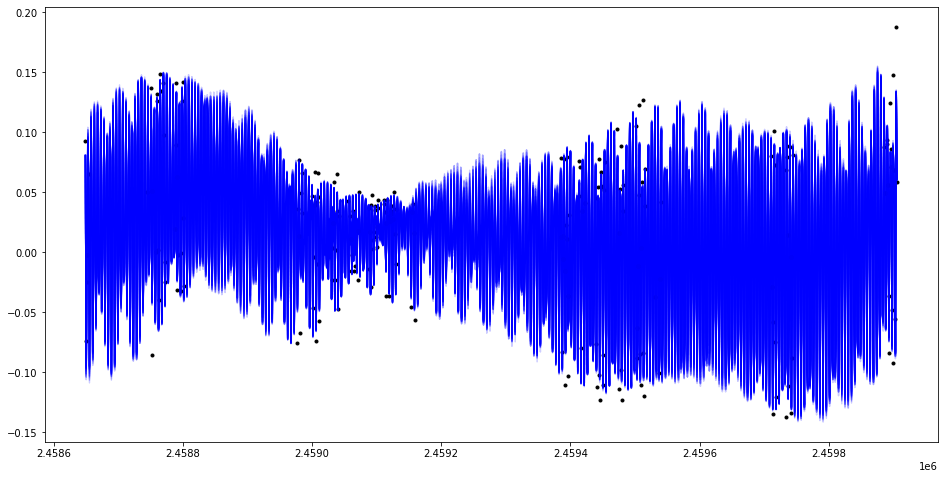

In [143]:
plt.figure(figsize=(16, 8))

plt.plot(times[:-1], eigen2vectors[2][:-1],'k.')
tplot = np.linspace(np.min(times[:-1]), np.max(times[:-1]), 1000)
 
for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
plt.show()

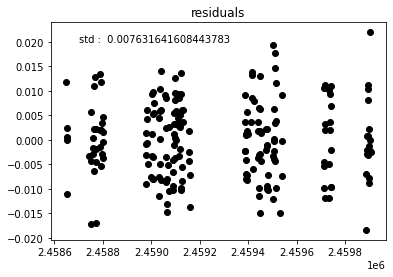

In [144]:
y_sample = Display(flat_samples[0,:], times[:-1])

residuals = eigen2vectors[2][:-1] - y_sample

plt.plot(times[:-1], residuals, 'ok')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, 0.02) )
plt.title('residuals')
plt.show()